### ARIMA - Autoregressive Integrated Moving Average
### ARIMA(p,d,q) using dataset `Combined_Raw.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

# Read and inspect the data
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Raw.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Columns: 128 entries, date to Cushing, OK WTI Spot Price FOB (Dollars per Barrel)
dtypes: float64(97), int64(30), object(1)
memory usage: 450.1+ KB


#### Inspect the data, specifically the target

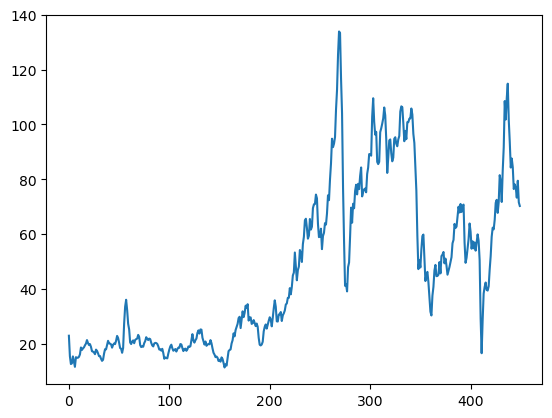

In [2]:
oil_prices = df['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']
oil_prices.plot()
plt.show()

# Check for Stationarity with Augmented Dickey-Fuller Test

In [3]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'{key}: {value}')


test_stationarity(oil_prices)

ADF Statistic: -1.92534780864869
p-value: 0.32023224979675374
1%: -3.4451978474132234
5%: -2.8680864144212057
10%: -2.5702569996789792


In [4]:
# Differencing to achieve stationarity
diff_oil_prices = oil_prices.diff().dropna()
test_stationarity(diff_oil_prices)

ADF Statistic: -10.117262323167331
p-value: 9.65073599677006e-18
1%: -3.4451978474132234
5%: -2.8680864144212057
10%: -2.5702569996789792


In [5]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(oil_prices) * 0.8)
train, test = oil_prices[:train_size], oil_prices[train_size:]

## Auto ARIMA Model: Find the best parameters for an ARIMA model

In [6]:
# Fit auto_arima model to find optimal parameters
auto_model = auto_arima(train, seasonal=False, trace=True, suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2008.468, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2073.452, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2014.312, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2027.561, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2071.482, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2015.335, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2016.408, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2010.286, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2010.347, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2015.748, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2012.830, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2008.286, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2014.695, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2010.286, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2015.482, Time=0.07 sec
 ARIMA(4,1

## Train the ARIMA Model

In [7]:
# Train ARIMA model with the best parameters
model = ARIMA(train, order=auto_model.order)
results = model.fit()

### Forecasting with ARIMA:

In [8]:
# Forecasting
forecast = results.get_forecast(steps=len(test)) # Forecast the same length as the test set because we want to compare the predictions to the actual values
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

### Plot the results:

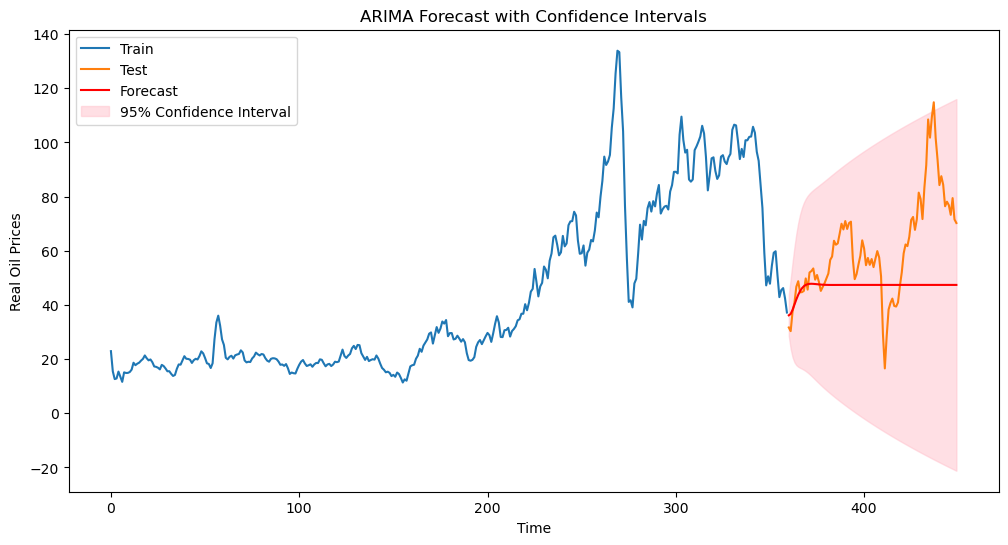

In [9]:
# Plot the results with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Real Oil Prices')
plt.title('ARIMA Forecast with Confidence Intervals')
plt.legend()
plt.show()

### Evaluate the model:

In [10]:
# Evaluate the model
mae = mean_absolute_error(test, forecast_mean)
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 16.798362901206385
MSE: 522.1346422401017
RMSE: 22.850265692987065
MAPE: 25.48310152272609%


### Model Evaluation:

#### First Attempt:
- MAE (Mean Absolute Error):
    - Value: 16.798362901206385
    - Interpretation: On average, the forecast is off by about 7.0446 units.

- MSE (Mean Squared Error):
    - Value: 522.1346422401017
    - Interpretation: It gives more weight to larger errors. This metric can be useful when you want to penalize larger errors more than smaller ones.

- RMSE (Root Mean Squared Error):
    - Value: 22.850265692987065
    - Interpretation: This is the square root of the MSE and provides the error in the same units as the original data. In this case, the forecast is off by an average of about 8.0256 units. RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable.

- MAPE (Mean Absolute Percentage Error):
    - Value: 25.48310152272609%
    - Interpretation: On average, the forecast is off by about 24.65%. This is a relative measure and is often used to compare the forecasting abilities of different methods for a particular series.

## Future Forecasting with ARIMA:

In [11]:
# Future Forecasting beyond available data
n_periods = 30
future_forecast = results.get_forecast(steps=n_periods)
future_forecast_mean = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()

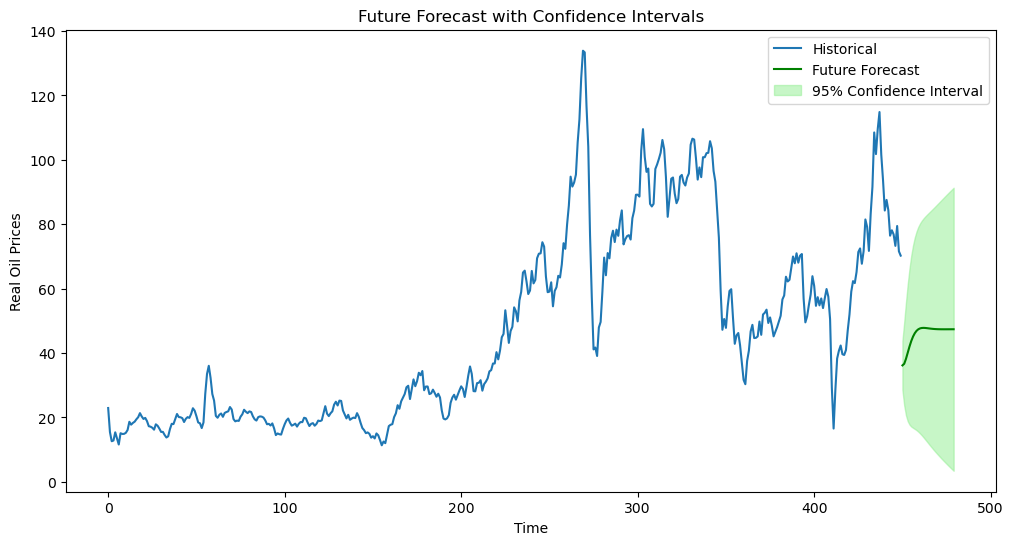

In [12]:
# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(oil_prices.index, oil_prices, label='Historical')
plt.plot(np.arange(len(oil_prices), len(oil_prices) + n_periods), future_forecast_mean, color='green', label='Future Forecast')
plt.fill_between(np.arange(len(oil_prices), len(oil_prices) + n_periods), future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='lightgreen', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Real Oil Prices')
plt.title('Future Forecast with Confidence Intervals')
plt.legend()
plt.show()

A 95% confidence interval is a range of values that you can be 95% certain contains the true mean of the population. In the context of forecasting with models like ARIMA, a 95% confidence interval around a forecasted value means that if you were to make a large number of additional samples, then 95% of the time, the true future value would fall within that range.

In forecasting, we use past data to make educated guesses about the future. The 95% confidence interval tells us that, based on this past data, we're pretty sure (95% sure, to be exact) that the actual future value will land within a certain range. It's like saying, "Based on how things have gone before, I'm 95% confident that sales next month will be between $1,000 and $1,200."

Why not 100%? Because there's always some uncertainty. Maybe there's an unusual event that affects sales, or perhaps there's just random fluctuation that we can't predict. The 95% confidence interval accounts for that usual level of unpredictability, but not for truly exceptional or random events.